In [2]:
# =============================================================================
# Análisis de correlación y regresión (Ejercicio B)
# Descriptivos, normalidad (Shapiro), correlaciones (Pearson/Spearman),
# regresión OLS, diagnósticos (residuos, BP), y conclusiones en lenguaje claro.
# =============================================================================

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt

# -----------------------------
# 1) Datos
# -----------------------------
x = np.array([2,1,20,21,33,35,37,36,39,38,32,28,27,36,35,34,37,38,39,37,38,39,55,52,35], dtype=float)
y = np.array([0,0,25000,26000,30000,18000,18000,18000,15000,15000,29000,28000,26000,17000,16000,
              18000,19000,16000,14000,19000,14000,13000,55000,48000,15000], dtype=float)

df = pd.DataFrame({"x": x, "y": y})



In [3]:
# -----------------------------
# 2) Descriptivos
# -----------------------------
def descriptivos(serie):
    return {
        "n": serie.size,
        "media": np.mean(serie),
        "mediana": np.median(serie),
        "desv_std": np.std(serie, ddof=1),
        "min": np.min(serie),
        "max": np.max(serie),
        "asimetria": stats.skew(serie, bias=False)
    }

desc_x = descriptivos(df["x"].values)
desc_y = descriptivos(df["y"].values)

print("=== DESCRIPTIVOS ===")
for nombre, d in [("x", desc_x), ("y", desc_y)]:
    print(f"\nVariable {nombre}:")
    for k, v in d.items():
        if isinstance(v, float):
            print(f"  - {k}: {v:,.4f}")
        else:
            print(f"  - {k}: {v}")



=== DESCRIPTIVOS ===

Variable x:
  - n: 25
  - media: 32.9600
  - mediana: 36.0000
  - desv_std: 12.0190
  - min: 1.0000
  - max: 55.0000
  - asimetria: -1.2419

Variable y:
  - n: 25
  - media: 20,480.0000
  - mediana: 18,000.0000
  - desv_std: 11,902.8008
  - min: 0.0000
  - max: 55,000.0000
  - asimetria: 1.2189


In [4]:
# -----------------------------
# 3) Pruebas de normalidad (Shapiro-Wilk)
#    H0: Los datos provienen de una distribución normal.
#    H1: Los datos NO provienen de una distribución normal.
# -----------------------------
sh_x = stats.shapiro(df["x"].values)
sh_y = stats.shapiro(df["y"].values)

def interpreta_shapiro(resultado, varname, alpha=0.05):
    stat, p = resultado.statistic, resultado.pvalue
    decision = "No se rechaza H0 (compatible con normalidad)" if p >= alpha else "Se rechaza H0 (no normal)"
    return f"{varname}: W={stat:.4f}, p={p:.4g} -> {decision}"

print("\n=== NORMALIDAD (Shapiro-Wilk) ===")
print(interpreta_shapiro(sh_x, "x"))
print(interpreta_shapiro(sh_y, "y"))




=== NORMALIDAD (Shapiro-Wilk) ===
x: W=0.8288, p=0.0007154 -> Se rechaza H0 (no normal)
y: W=0.8562, p=0.002315 -> Se rechaza H0 (no normal)


In [5]:
# -----------------------------
# 4) Correlaciones
#    - Pearson (si hay normalidad aproximada)
#    - Spearman (robusto a no normalidad y no linealidad monótona)
#    Hipótesis (para ambos):
#      H0: ρ = 0 (no hay asociación)
#      H1: ρ ≠ 0 (sí hay asociación)
# -----------------------------
pearson_r, pearson_p = stats.pearsonr(df["x"], df["y"])
spearman_rho, spearman_p = stats.spearmanr(df["x"], df["y"])

print("\n=== CORRELACIÓN ===")
print(f"Pearson: r = {pearson_r:,.4f}, p = {pearson_p:.4g}")
print(f"Spearman: ρ = {spearman_rho:,.4f}, p = {spearman_p:.4g}")

# Interpretación breve
def interpreta_corr(nombre, r, p, alpha=0.05):
    fuerza = ("muy débil", "débil", "moderada", "fuerte")
    ar = abs(r)
    if ar < 0.2: f = fuerza[0]
    elif ar < 0.4: f = fuerza[1]
    elif ar < 0.7: f = fuerza[2]
    else: f = fuerza[3]
    sig = "significativa" if p < alpha else "no significativa"
    sentido = "positiva" if r > 0 else ("negativa" if r < 0 else "nula")
    return f"{nombre}: asociación {f}, {sentido}, {sig} (p={p:.4g})."

print("\n- Interpretación correlaciones:")
print("  " + interpreta_corr("Pearson", pearson_r, pearson_p))
print("  " + interpreta_corr("Spearman", spearman_rho, spearman_p))




=== CORRELACIÓN ===
Pearson: r = 0.6124, p = 0.001139
Spearman: ρ = -0.0633, p = 0.7636

- Interpretación correlaciones:
  Pearson: asociación moderada, positiva, significativa (p=0.001139).
  Spearman: asociación muy débil, negativa, no significativa (p=0.7636).


In [6]:
# -----------------------------
# 5) Regresión lineal (OLS): y = β0 + β1*x
#    - Estimación, R^2, p-valores
#    - Diagnósticos: normalidad de residuos, homocedasticidad (Breusch-Pagan)
# -----------------------------
X = sm.add_constant(df["x"])  # agrega intercepto
modelo = sm.OLS(df["y"], X).fit()

print("\n=== REGRESIÓN LINEAL OLS (y ~ x) ===")
print(modelo.summary())

# Diagnósticos
residuos = modelo.resid
sh_res = stats.shapiro(residuos)
bp_test = het_breuschpagan(residuos, X)  # (Lagrange multiplier, pval, fval, f_pval)
lm_stat, lm_pvalue, f_stat, f_pvalue = bp_test

print("\n=== DIAGNÓSTICOS DE REGRESIÓN ===")
print(f"Normalidad de residuos (Shapiro): W={sh_res.statistic:.4f}, p={sh_res.pvalue:.4g}")
print(f"Breusch-Pagan (H0: varianza constante): LM={lm_stat:.4f}, p={lm_pvalue:.4g} | F={f_stat:.4f}, p={f_pvalue:.4g}")




=== REGRESIÓN LINEAL OLS (y ~ x) ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     13.80
Date:                Fri, 15 Aug 2025   Prob (F-statistic):            0.00114
Time:                        03:12:18   Log-Likelihood:                -263.70
No. Observations:                  25   AIC:                             531.4
Df Residuals:                      23   BIC:                             533.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        4

In [7]:
# -----------------------------
# 6) Conclusiones
# -----------------------------
alpha = 0.05

print("\n=== CONCLUSIONES (en lenguaje claro) ===")

# Normalidad
def concl_norm(sh, var):
    return (f"- {var}: Los datos son compatibles con normalidad (p={sh.pvalue:.4g})."
            if sh.pvalue >= alpha else
            f"- {var}: Los datos NO parecen normales (p={sh.pvalue:.4g}).")
print(concl_norm(sh_x, "x"))
print(concl_norm(sh_y, "y"))

# Correlación
if pearson_p < alpha:
    print(f"- Hay evidencia de asociación lineal entre x e y (Pearson r={pearson_r:.3f}, p={pearson_p:.4g}).")
else:
    print(f"- No se encontró evidencia suficiente de correlación lineal (Pearson p={pearson_p:.4g}).")

if spearman_p < alpha:
    print(f"- También se observa asociación monótona (Spearman ρ={spearman_rho:.3f}, p={spearman_p:.4g}).")
else:
    print(f"- Spearman no indica asociación monótona significativa (p={spearman_p:.4g}).")

# Regresión
p_beta1 = modelo.pvalues["x"]
beta1 = modelo.params["x"]
r2 = modelo.rsquared
if p_beta1 < alpha:
    print(f"- La pendiente es significativa: β1={beta1:,.2f} (p={p_beta1:.4g}). En promedio, por cada unidad de x, y cambia {beta1:,.2f} unidades.")
    print(f"- El ajuste explica el {r2*100:.1f}% de la variabilidad de y (R²={r2:.3f}).")
else:
    print(f"- La pendiente no es significativa (p={p_beta1:.4g}); el modelo lineal no explica bien y.")

# Residuos
if sh_res.pvalue >= alpha:
    print(f"- Residuos compatibles con normalidad (Shapiro p={sh_res.pvalue:.4g}).")
else:
    print(f"- Residuos no normales (Shapiro p={sh_res.pvalue:.4g}); considerar transformaciones/robustos.")

if lm_pvalue >= alpha:
    print(f"- No se detecta heterocedasticidad (Breusch-Pagan p={lm_pvalue:.4g}).")
else:
    print(f"- Indicios de heterocedasticidad (Breusch-Pagan p={lm_pvalue:.4g}); considerar errores robustos o transformación.")




=== CONCLUSIONES (en lenguaje claro) ===
- x: Los datos NO parecen normales (p=0.0007154).
- y: Los datos NO parecen normales (p=0.002315).
- Hay evidencia de asociación lineal entre x e y (Pearson r=0.612, p=0.001139).
- Spearman no indica asociación monótona significativa (p=0.7636).
- La pendiente es significativa: β1=606.43 (p=0.001139). En promedio, por cada unidad de x, y cambia 606.43 unidades.
- El ajuste explica el 37.5% de la variabilidad de y (R²=0.375).
- Residuos no normales (Shapiro p=0.004241); considerar transformaciones/robustos.
- Indicios de heterocedasticidad (Breusch-Pagan p=0.01903); considerar errores robustos o transformación.


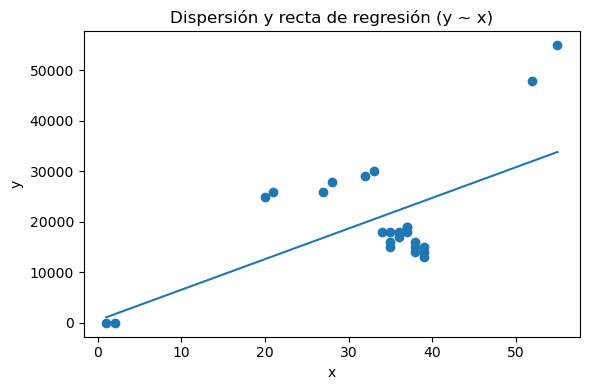

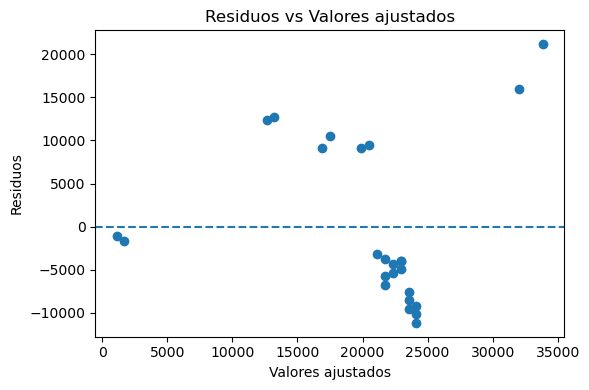

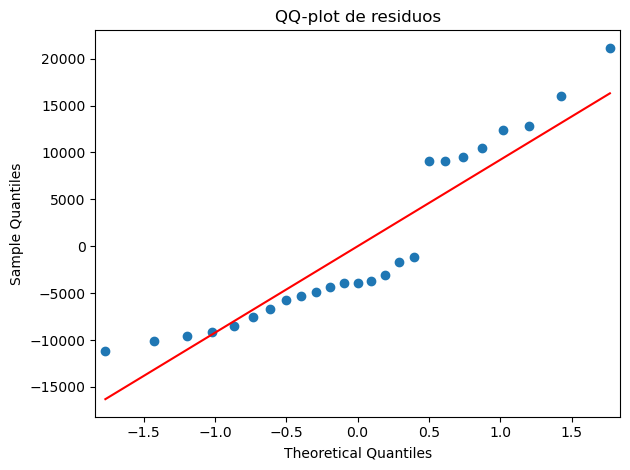

In [8]:
# -----------------------------
# 7) Gráficos 
# -----------------------------
plt.figure(figsize=(6,4))
plt.scatter(df["x"], df["y"])
# recta ajustada
x_line = np.linspace(df["x"].min(), df["x"].max(), 100)
y_line = modelo.params["const"] + modelo.params["x"]*x_line
plt.plot(x_line, y_line)
plt.title("Dispersión y recta de regresión (y ~ x)")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(modelo.fittedvalues, residuos)
plt.axhline(0, linestyle="--")
plt.title("Residuos vs Valores ajustados")
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.tight_layout()
plt.show()

sm.qqplot(residuos, line="s")
plt.title("QQ-plot de residuos")
plt.tight_layout()
plt.show()


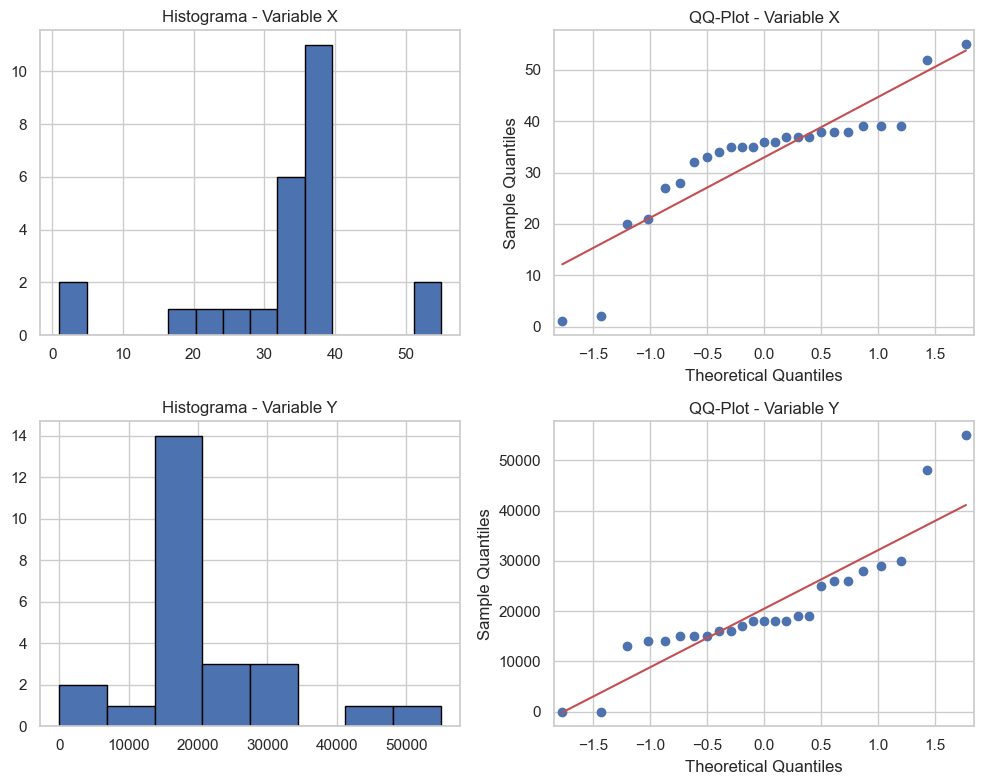

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Datos como numpy arrays (¡clave para evitar el error!)
x = np.array([2,1,20,21,33,35,37,36,39,38,32,28,27,36,35,34,37,38,39,37,38,39,55,52,35], dtype=float)
y = np.array([0,0,25000,26000,30000,18000,18000,18000,15000,15000,29000,28000,26000,17000,
              16000,18000,19000,16000,14000,19000,14000,13000,55000,48000,15000], dtype=float)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Histograma X
axes[0, 0].hist(x, bins='auto', edgecolor='black')
axes[0, 0].set_title('Histograma - Variable X')

# QQ-plot X
sm.qqplot(x, line='s', ax=axes[0, 1])
axes[0, 1].set_title('QQ-Plot - Variable X')

# Histograma Y
axes[1, 0].hist(y, bins='auto', edgecolor='black')
axes[1, 0].set_title('Histograma - Variable Y')

# QQ-plot Y
sm.qqplot(y, line='s', ax=axes[1, 1])
axes[1, 1].set_title('QQ-Plot - Variable Y')

plt.tight_layout()
plt.show()


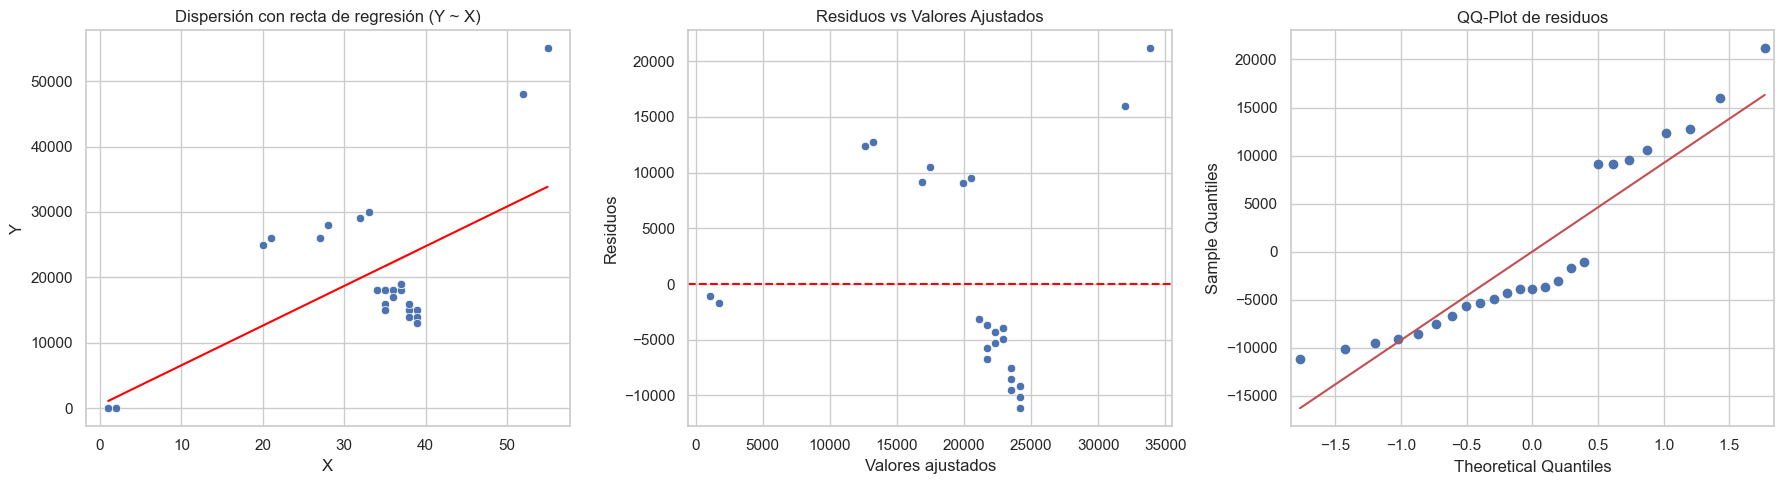

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

# Datos
x = np.array([2,1,20,21,33,35,37,36,39,38,32,28,27,36,35,34,37,38,39,37,38,39,55,52,35], dtype=float)
y = np.array([0,0,25000,26000,30000,18000,18000,18000,15000,15000,29000,28000,26000,17000,
              16000,18000,19000,16000,14000,19000,14000,13000,55000,48000,15000], dtype=float)

# Modelo de regresión lineal
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()

# Valores ajustados y residuos
y_pred = model.fittedvalues
residuos = model.resid

# Crear figura
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Dispersión con recta de regresión
sns.scatterplot(x=x, y=y, ax=axes[0])
sns.lineplot(x=x, y=y_pred, color="red", ax=axes[0])
axes[0].set_title("Dispersión con recta de regresión (Y ~ X)")
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")

# 2. Residuos vs valores ajustados
sns.scatterplot(x=y_pred, y=residuos, ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title("Residuos vs Valores Ajustados")
axes[1].set_xlabel("Valores ajustados")
axes[1].set_ylabel("Residuos")

# 3. QQ-plot de residuos
sm.qqplot(residuos, line='s', ax=axes[2])
axes[2].set_title("QQ-Plot de residuos")

plt.tight_layout()
plt.show()
